# ECT of image data

#### Sarah McGuire November, 2023

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [3]:
import os
from os import listdir

In [4]:
import demeter.euler as euler
import demeter.directions as dirs
import demeter.misc as misc
import time
import tifffile as tf

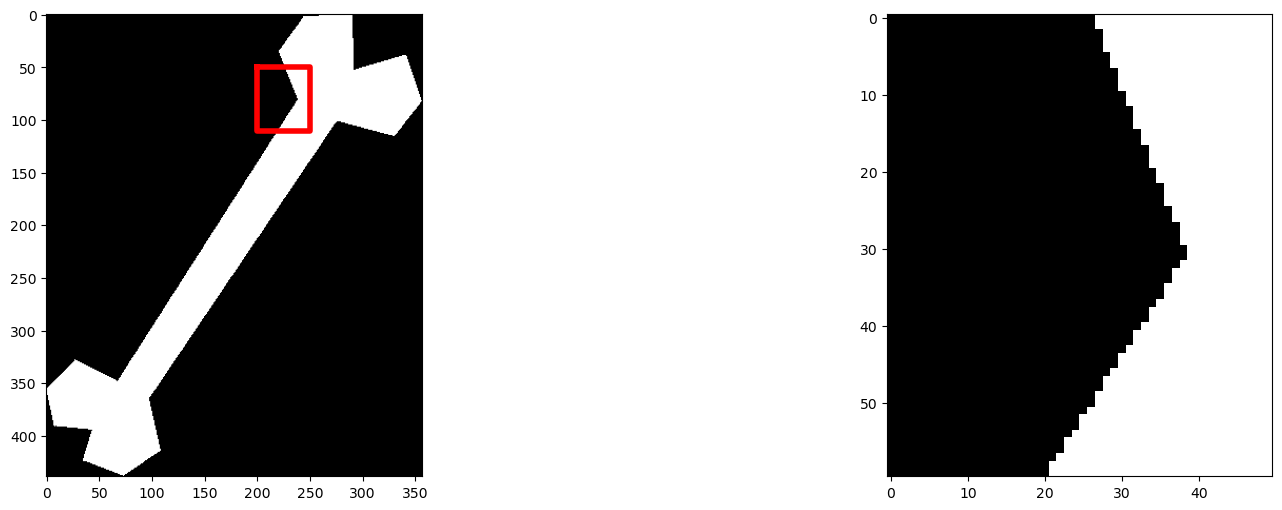

In [4]:
bone_img = Image.open('../data/MPEG7original/bone-3.gif')
bone_img = np.array(bone_img)
bone_img[bone_img > 0] = 1

fig, ax = plt.subplots(1,2,figsize=(20,6))
ax[0].imshow(bone_img, cmap='gray');
ax[0].plot([200,200,250,250,200], [50,110,110,50,50], c='red', lw=4);
ax[1].imshow(bone_img[50:110, 200:250], cmap='gray');

In [5]:
tic = time.perf_counter()
bone = euler.CubicalComplex(bone_img).complexify()
toc = time.perf_counter()

print("Complexify in {:.4f} seconds.\n\nCubical complex made of:".format(toc-tic))

bone.summary();

Complexify in 0.5581 seconds.

Cubical complex made of:
28520	vertices
56156	edges
27637	squares
----
Euler Characteristic: 1


In [8]:
def ECC(image, theta, numThresh, plot=False):
    
    omega = (np.cos(theta), np.sin(theta))
    heights = np.sum(image.cells[0]*omega, axis=1)


    threshes= np.linspace(heights.min(), heights.max(), numThresh)

    outECC = image.ECC(heights, numThresh)

    if plot:
        plt.step(threshes,outECC)
        plt.title(r'ECC for $\omega = \frac{3 \pi}{4}$')
        plt.xlabel('$a$')
        plt.ylabel(r'$\chi(K_a)$')

        plt.savefig('figures/Fern_3pi_over_4_ECC.png', bbox_inches = 'tight')
    
    return outECC

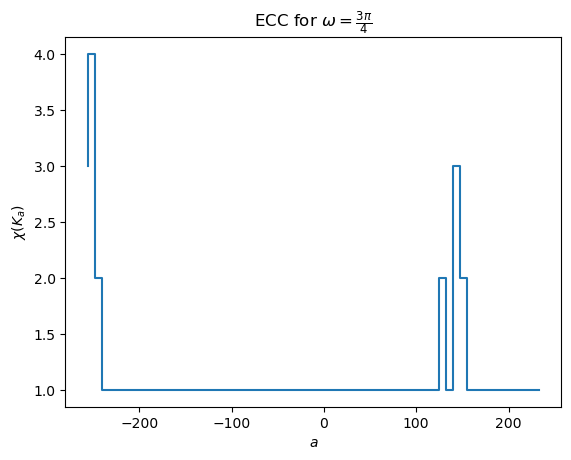

In [7]:
ecc = ECC(image = bone, theta = 3*np.pi/4, numThresh = 64, plot=True )

## Generate dataset of ECT images

In [6]:
# Choose number of thresholds for the ECC and number of directions for ECT
numCircleDirs = 32
        
numThresh = 48

KeyboardInterrupt: 

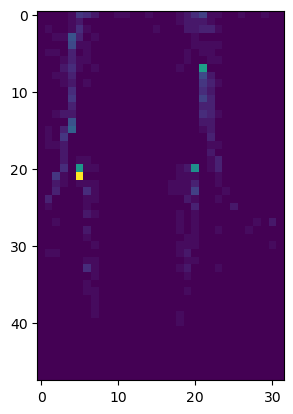

In [29]:
# get the path/directory
folder_dir = "../data/MPEG7original/"
dataset = []
for images in os.listdir(folder_dir):
    
    # check if the image ends with png
    if (images.endswith(".gif")):
        
        #load image
        img = Image.open(folder_dir+images)
        img = np.array(img)
        img[img > 0] = 1

    
        # Complexify the image
        image = euler.CubicalComplex(img).complexify()
        
        
        # Select directions around the circle
        circledirs =  np.linspace(0, 2*np.pi, num=numCircleDirs, endpoint=False)


        # Compute the ECT of image complex for numCircleDirs, numThresh
        ECT_preprocess = {}
        for i, angle in enumerate(circledirs):

            outECC = ECC(image, theta=angle, numThresh = numThresh, plot=False)

            ECT_preprocess[i] = (angle,outECC)

        # Making a matrix M[i,j]: (numThresh x numCircleDirs)
        M = np.empty([numThresh,numCircleDirs])
        for j in range(M.shape[1]):
            M[:,j] = ECT_preprocess[j][1]

        plt.imshow(M)
        # Rescale the array pixel values to [0, 255]-- > wait until data loader transform for Normalization
        # This is necessary to save as grayscale image (because the ECT has negative integer values)
        M_scale = (255*(M - np.min(M))/np.ptp(M)).astype(np.uint8)


        # Convert to greyscale image using PIL
        M_img = Image.fromarray(M_scale)

        
        # NPY file to save
        filename = 'data_ECT_MPEG7/'+str(numCircleDirs)+'dirs_'+str(numThresh)+'thresh_NPY/'+str(images[:-4])
        np.save(filename, M)
        
        # flatten array and append to dataset list for statistics computation of entire dataset
        dataset.append(M.flatten())
        
        

In [20]:
# calculate global min, max, average, and standard deviation of dataset for normalization later
global_mean = np.mean(dataset)
global_std = np.std(dataset)
global_min = np.min(dataset)
global_max = np.max(dataset)

In [21]:
print('----------------')
print('Dataset statistics')
print('----------------')
print('min:', global_min)
print('max:', global_max)
print('mean:', global_mean)
print('std:', global_std)

----------------
Dataset statistics
----------------
min: -197.0
max: 147.0
mean: -1.4867638578869047
std: 13.72704149416465


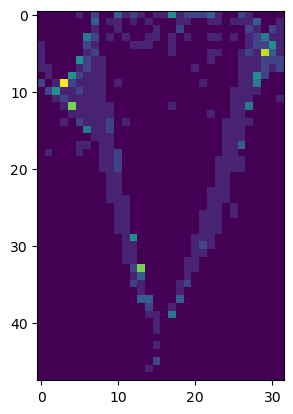

In [9]:
folder_dir = "../data/MPEG7original/"
images = 'apple-3.gif'
#load image
img = Image.open(folder_dir+images)
img = np.array(img)
img[img > 0] = 1


# Complexify the image
image = euler.CubicalComplex(img).complexify()


# Select directions around the circle
circledirs =  np.linspace(0, 2*np.pi, num=numCircleDirs, endpoint=False)


# Compute the ECT of image complex for numCircleDirs, numThresh
ECT_preprocess = {}
for i, angle in enumerate(circledirs):

    outECC = ECC(image, theta=angle, numThresh = numThresh, plot=False)

    ECT_preprocess[i] = (angle,outECC)

# Making a matrix M[i,j]: (numThresh x numCircleDirs)
M = np.empty([numThresh,numCircleDirs])
for j in range(M.shape[1]):
    M[:,j] = ECT_preprocess[j][1]

plt.imshow(M)

        
  

In [23]:
def neighborhood_setup(dimension, downsample = 1):
    neighs = sorted(list(itertools.product(range(2), repeat=dimension)), key=np.sum)[1:]
    neighs = list(map(tuple, np.array(neighs)*downsample))
    subtuples = dict()
    for i in range(len(neighs)):
        subtup = [0]
        for j in range(len(neighs)):
            if np.all(np.subtract(neighs[i], neighs[j]) > -1):
                subtup.append(j+1)
        subtuples[neighs[i]] = subtup

    return neighs, subtuples

def neighborhood(voxel, neighs, hood, dcoords):
    hood[0] = dcoords[voxel]
    neighbors = np.add(voxel, neighs)
    for j in range(1,len(hood)):
        key = tuple(neighbors[j-1,:])
        if key in dcoords:
            hood[j] = dcoords[key]
    return hood

def centerVertices(verts):
    origin = -1*np.mean(verts, axis=0)
    verts = np.add(verts, origin)
    return verts

class CubicalComplex:

    def __init__(self, img):
        self.img = img

    def complexify(self, center=True, downsample=1):
        scoords = np.nonzero(self.img)
        scoords = np.vstack(scoords).T

        skip = np.zeros(self.img.ndim, dtype=int) + downsample
        coords = scoords[np.all(np.fmod(scoords, skip) == 0, axis=1), :]

        keys = [tuple(coords[i,:]) for i in range(len(coords))]
        dcoords = dict(zip(keys, range(len(coords))))
        neighs, subtuples = neighborhood_setup(self.img.ndim, downsample)
        binom = [special.comb(self.img.ndim, k, exact=True) for k in range(self.img.ndim+1)]

        hood = np.zeros(len(neighs)+1, dtype=np.int)-1
        cells = [[] for k in range(self.img.ndim+1)]

        for voxel in dcoords:
            hood.fill(-1)
            hood = neighborhood(voxel, neighs, hood, dcoords)
            nhood = hood > -1
            c = 0
            if np.all(nhood[:-1]):
                for k in range(1, self.img.ndim):
                    for j in range(binom[k]):
                        cell = hood[subtuples[neighs[c]]]
                        cells[k].append(cell)
                        c += 1
                if nhood[-1]:
                    cells[self.img.ndim].append(hood.copy())
            else:
                for k in range(1, self.img.ndim):
                    for j in range(binom[k]):
                        cell = nhood[subtuples[neighs[c]]]
                        if np.all(cell):
                            cells[k].append(hood[subtuples[neighs[c]]])
                        c += 1

        dim = self.img.ndim
        for k in range(dim, -1, -1):
            if len(cells[k]) > 0:
                break

        self.ndim = dim
        self.cells = [np.array(cells[k]) for k in range(dim+1)]
        if center:
            self.cells[0] = centerVertices(coords)
        else:
            self.cells[0] = coords

        return self


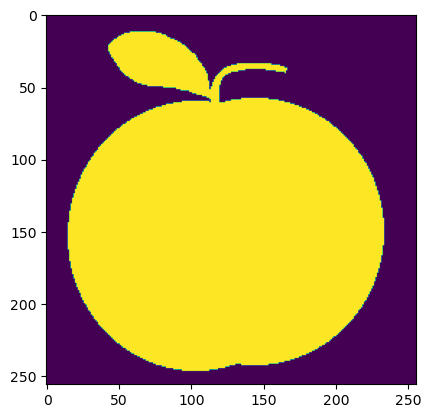

In [24]:
plt.imshow(img)

In [27]:
import itertools
import scipy.special as special
img_new = CubicalComplex(img).complexify()

/var/folders/j1/837t9x6s48l8_l8tzvqv94mw0000gn/T/ipykernel_36906/3577018924.py:45: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  hood = np.zeros(len(neighs)+1, dtype=np.int)-1


<AxesSubplot:>

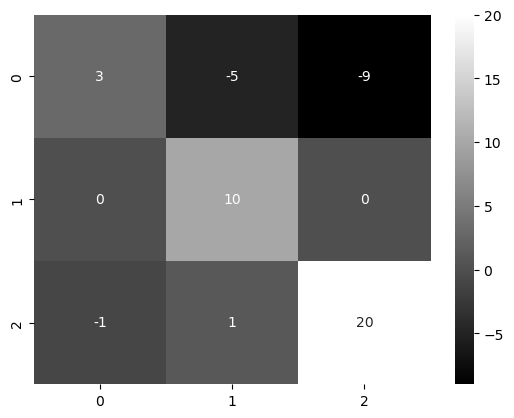

In [69]:
sns.heatmap(A, cmap='gray', annot=True)

In [70]:
A_scale = (255*(A - np.min(A))/np.ptp(A)).astype(np.uint8)

<AxesSubplot:>

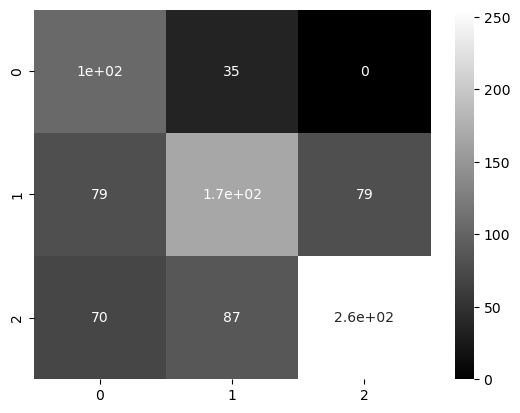

In [71]:
sns.heatmap(A_scale, cmap='gray', annot=True)

In [74]:
np.min(A_scale)

0